<a href="https://colab.research.google.com/github/benjaminsw/generic-VI/blob/main/VI_code_sample_1_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook, I aim to examine generic variational inference code. The first code is from: https://zhiyzuo.github.io/VI/

1.01:
- generalised plot
- scale param in <code>np.random.normal()</code>

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## ELBO term in 'get_elbo(self)':
$\mathcal{L}_{\theta,\phi}(\mathbf{x})=\mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})}[\log p_{\theta}(\mathbf{x},\mathbf{z})+ \mathcal{H}(q)\ (entropy\ of\ q) $



* The first term prefers q(z) to be high when complete likelihood p(x,z) is high
* The second term encourages q(z) to be diffuse across the space




In [15]:
class UGMM(object):
    '''Univariate GMM with CAVI'''
    def __init__(self, X, K=2, sigma=1):
        self.X = X
        self.K = K
        self.N = self.X.shape[0]                                                # number of rows in X
        self.sigma2 = sigma**2

    def _init(self):
        self.phi = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*self.K, self.N)
        self.m = np.random.randint(int(self.X.min()), high=int(self.X.max()), size=self.K).astype(float)
        self.m += self.X.max()*np.random.random(self.K)                         # generate means in accordance with the number of K
        self.s2 = np.ones(self.K) * np.random.random(self.K)                    # generate variences in accordance with the number of K
        print('Init mean') # print means
        print(self.m)
        print('Init s2') # print varience
        print(self.s2)
        print('Init N') # print number of rows
        print(self.N)
        print('Init X') # print X
        print(self.X)
        print('range of X (min-max)')
        print([self.X.min(), self.X.max()])
        print('---End Init---')

    def get_elbo(self):
        t1 = np.log(self.s2) - self.m/self.sigma2
        t1 = t1.sum()
        t2 = -0.5*np.add.outer(self.X**2, self.s2+self.m**2)
        t2 += np.outer(self.X, self.m)
        t2 -= np.log(self.phi)
        t2 *= self.phi
        t2 = t2.sum()
        return t1 + t2

    def fit(self, max_iter=100, tol=1e-10):
        self._init()
        self.elbo_values = [self.get_elbo()]
        self.m_history = [self.m]
        self.s2_history = [self.s2]
        for iter_ in range(1, max_iter+1):
            self._cavi()
            self.m_history.append(self.m)
            self.s2_history.append(self.s2)
            self.elbo_values.append(self.get_elbo())
            if iter_ % 5 == 0:
                print(iter_, self.m_history[iter_])
            if np.abs(self.elbo_values[-2] - self.elbo_values[-1]) <= tol:
                print('ELBO converged with ll %.3f at iteration %d'%(self.elbo_values[-1],
                                                                     iter_))
                break

        if iter_ == max_iter:
            print('ELBO ended with ll %.3f'%(self.elbo_values[-1]))


    def _cavi(self):
        self._update_phi()
        self._update_mu()

    def _update_phi(self):
        t1 = np.outer(self.X, self.m)
        t2 = -(0.5*self.m**2 + 0.5*self.s2)
        exponent = t1 + t2[np.newaxis, :]
        self.phi = np.exp(exponent)
        self.phi = self.phi / self.phi.sum(1)[:, np.newaxis]

    def _update_mu(self):
        self.m = (self.phi*self.X[:, np.newaxis]).sum(0) * (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.m.size == self.K
        #print(self.m)
        self.s2 = (1/self.sigma2 + self.phi.sum(0))**(-1)
        assert self.s2.size == self.K

In [16]:
num_components = 4
mu_arr = np.random.choice(np.arange(-10, 10, 2),
                          num_components) +\
         np.random.random(num_components)
mu_arr

array([ 0.62373795,  2.17459655, -1.68763027,  2.72850358])

In [17]:
SAMPLE = 1000

In [18]:
# making a vector of X for each mu at a time, then append to the previous one to forom a metrix

X = np.random.normal(loc=mu_arr[0], scale=1, size=SAMPLE)
for i, mu in enumerate(mu_arr[1:]):
    X = np.append(X, np.random.normal(loc=mu, scale=1, size=SAMPLE))

<ipython-input-19-cb74f07fe211>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, rug=True)
<ipython-input-19-cb74f07fe211>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, rug=True)
<ipython-input-19-cb74f07fe211>:4: UserWarning: 

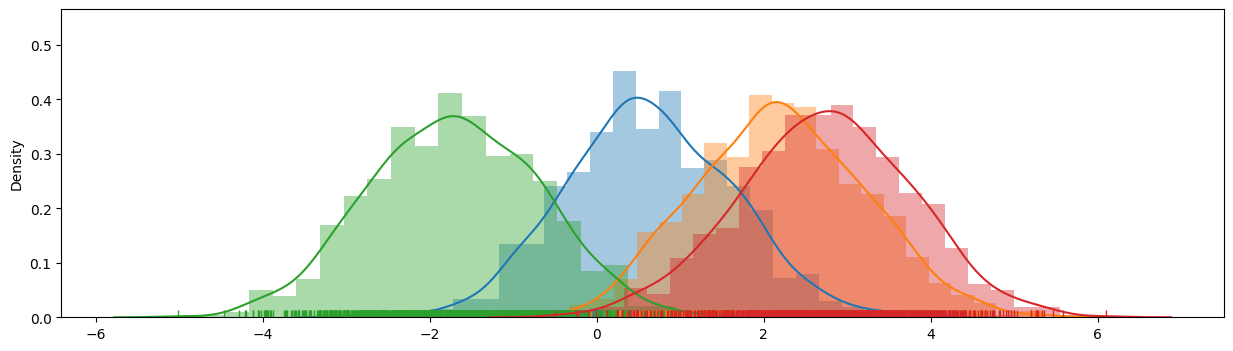

In [19]:
fig, ax = plt.subplots(figsize=(15, 4))
for c in range(0,num_components):
  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, rug=True)


In [20]:
ugmm = UGMM(X, num_components)
ugmm.fit()

Init mean
[2.47667314 8.05699776 6.04295289 5.68556132]
Init s2
[0.30431613 0.30112121 0.54500824 0.56360087]
Init N
4000
Init X
[1.23785242 0.96542511 1.65510546 ... 1.54339328 0.43891974 0.78100159]
range of X (min-max)
[-5.018715026779428, 6.100465076980937]
---End Init---
5 [-1.42906163  1.1717407   2.59295367  2.52667998]
10 [-1.65467166  0.73126446  2.56667426  2.46342162]
15 [-1.70377848  0.60618049  2.57356626  2.43148062]
20 [-1.71677193  0.57290981  2.59233624  2.40149403]
25 [-1.72057671  0.56451302  2.61998342  2.36783161]
30 [-1.72212033  0.56325743  2.65365675  2.32812915]
35 [-1.72324567  0.56449684  2.69031997  2.28368809]
40 [-1.72436959  0.56700655  2.72587552  2.23860804]
45 [-1.72544277  0.57027069  2.75635785  2.19800956]
50 [-1.72630794  0.57377717  2.77966761  2.16550194]
55 [-1.72688807  0.57702226  2.79595354  2.14191944]
60 [-1.72721807  0.57968161  2.80664674  2.12600983]
65 [-1.72738145  0.58166508  2.81340068  2.11578355]
70 [-1.7274531   0.58304516  2.8175

In [21]:
ugmm.phi.argmax(1)

array([1, 1, 3, ..., 3, 1, 1])

In [22]:
sorted(mu_arr)

[-1.6876302695266217, 0.6237379461170763, 2.174596545656817, 2.728503579392427]

<ipython-input-23-a4f80b6c74ed>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, hist=True, norm_hist=True)
<ipython-input-23-a4f80b6c74ed>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.random.normal(ugmm.m[c], 1, SAMPLE), color='k', hist=False, kd

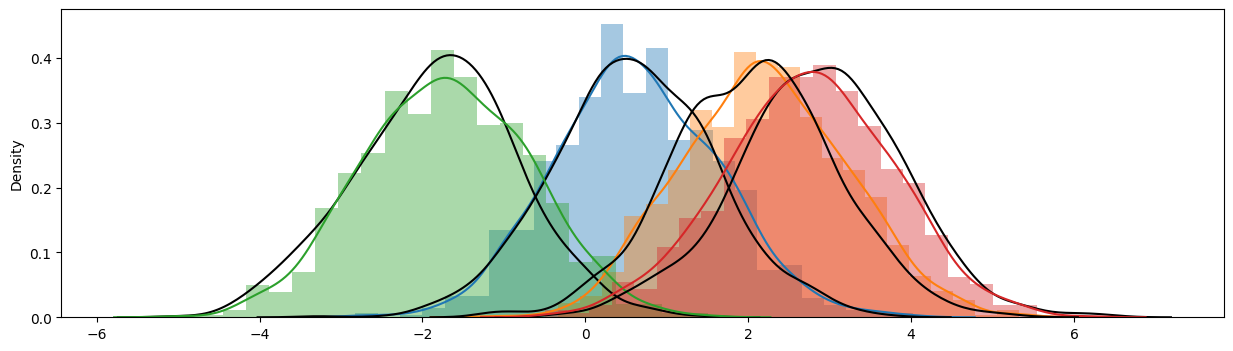

In [23]:
fig, ax = plt.subplots(figsize=(15, 4))
for c in range(0,num_components):
  sns.distplot(X[SAMPLE*c:SAMPLE*(c+1)], ax=ax, hist=True, norm_hist=True)
  sns.distplot(np.random.normal(ugmm.m[c], 1, SAMPLE), color='k', hist=False, kde=True)
